# HAT-P-44

[vizier](http://simbad.u-strasbg.fr/simbad/sim-id?protocol=html&Ident=HAT-P-44)
Obslog says file id=908-533

In [13]:
from glob import glob
try: 
    from astropy.io import fits as pf
except:
    import pyfits as pf
import numpy as np
from datetime import datetime as dt
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
%matplotlib inline
import os
import getpass
#import pandas as pd

#filedir='/media/jpdl/B838B30438B2C124/df_HATP44/'
#filedir='/mnt/B838B30438B2C124/df_HATP44/'

username = getpass.getuser()
filedir = os.path.join('/home',username,'data/hatp44_data')
output_dir = os.path.join('/home',username,'moscatel_output')

file_list = glob(os.path.join(filedir,'MSC*.fits')) 
file_list.sort()

len(file_list)

1457

In [7]:
from tqdm import tqdm

#check types of filters used in all images
filters=[]

for i in tqdm(file_list):
    z = pf.open(i)
    hdr = z[0].header
    if hdr['OBJECT']  == 'HAT-P-44':
        filters.append(hdr['FILTER'])
        
set(filters)

100%|██████████| 1457/1457 [00:05<00:00, 282.63it/s]


{'g', 'r', 'z_s'}

In [8]:
gband=[]
rband=[]
zband=[]

for i in tqdm(file_list):
    hdr = pf.open(i)[0].header
    #if hdr['OBJECT']  == 'HAT-P-44':
    if hdr['FILTER'] == 'g':
        gband.append(i)
    elif hdr['FILTER'] == 'r':
        rband.append(i)
    elif hdr['FILTER'] == 'z_s':
        zband.append(i)
    else: #redundancy
        print(i)
        
print('{0}\n{1}\n{2}'.format(len(gband), len(rband), len(zband)))

100%|██████████| 1457/1457 [00:04<00:00, 330.29it/s]

376
704
377


Why are there unequal number for each filter?

In [4]:
len(gband)+len(rband)+len(zband) == len(file_list)

True

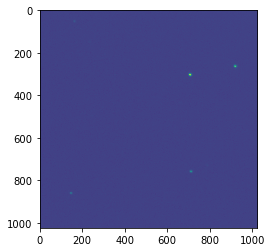

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

test_image = pf.open(gband[0])[0].data
plt.imshow(test_image)

## Stacking

 25%|██▌       | 2/8 [00:00<00:00, 13.12it/s]

Stacking 8 images


100%|██████████| 8/8 [00:00<00:00, 13.11it/s]


Shape of array to be stacked: (8, 1024, 1024)


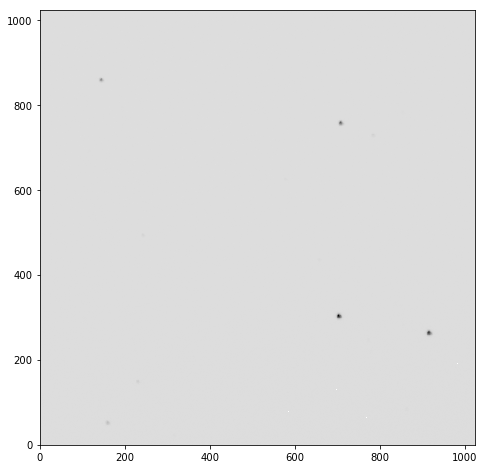

In [8]:
%matplotlib inline
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

def get_median(file_paths, n_slices, show_image=None, save_image=None):
    '''
    stack n-slices or all object images and returns stacked image
    '''

    # take 1457/n_slices = 30 images
    print('Stacking {0} images'.format(len(file_paths[::n_slices])))

    objs = np.array([pf.getdata("%s" % n) for n in tqdm(file_paths[::n_slices])])

    print('Shape of array to be stacked: {0}'.format(objs.shape))
    objs_stacked = np.median(objs, axis=0)
    
    fig = plt.figure(figsize=(8,8))
    
    if show_image: #default
        norm = ImageNormalize(stretch=SqrtStretch())
        plt.imshow(objs_stacked,cmap='Greys', origin='lower', norm=norm)
        plt.show()
    
    if save_image is True: #False by default
        fname='obj_med'+n_slices+'.fits'
        print('Saving stacked image as {}'.format(fname))
        pyfits.writeto(fname, objs_stacked, header=hdr)
    
    return objs_stacked

#trial: stack gband images

gband_stacked = get_median(gband, n_slices=50, show_image=True, save_image=False)

In [9]:
import numpy as np

x_est, y_est = 701, 304 #eyeball estimate of point source centroid
box_size = 100
image_array = np.array([pf.getdata("%s" % n) for n in tqdm(gband[::10])]) #stacking

100%|██████████| 38/38 [00:00<00:00, 58.51it/s]


In [10]:
image_array.shape

(38, 1024, 1024)

In [11]:
image_crop = []
add_stacked = []
median_stacked = []

for i in image_array:
    image_crop.append(i[int(y_est-(box_size/2)):int(y_est+(box_size/2)),int(x_est-(box_size/2)):int(x_est+(box_size/2))])
    add_stacked.append(sum(image_crop)) #add image instead of median stack
    median_stacked.append(np.median(image_crop,axis=0))

Check PSF of the point source with increasing number of images to be stacked:

(1) Linear adding

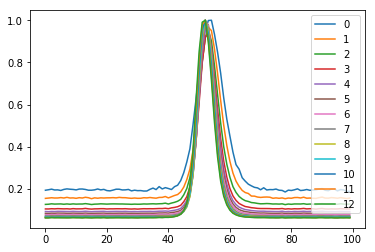

In [14]:
strip=[]
for idx,img in enumerate(add_stacked[::3]): #choose from 38 images sliced/ in increments of 3
    plt.plot(img[50,:]/np.max(img), label=idx)
    strip.append(img[50,:])
    
plt.legend()

(2) Element-wise median stacking

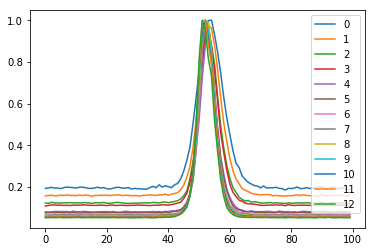

In [94]:
for idx,img in enumerate(median_stacked[::3]): #
    plt.plot(img[50,:]/np.max(img), label=idx)
    
plt.legend()

The psf shape becomes slightly skewed after taking the median.    

Take the psf (peak) for each image in the time series

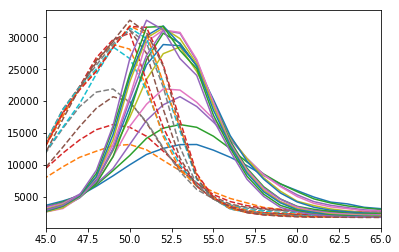

In [96]:
peak_x = []
peak_y = []

for idx,img in enumerate(median_stacked[::3]): #slice/ iterate every 3 images 
    i,j = np.unravel_index(img.argmax(), img.shape) #take x,y max
    plt.plot(img[i,:], '-')
    plt.plot(img[:,j], '--')
    peak_x.append(img[i,:])
    peak_y.append(img[:,j])
    
plt.xlim(45,65);

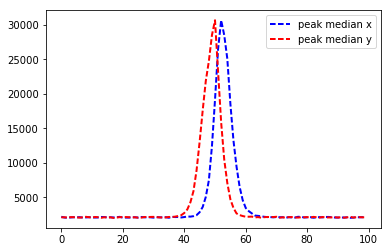

In [99]:
med_x=np.median(peak_x,axis=0)
med_y=np.median(peak_y,axis=0)

plt.plot(med_x, 'b--', lw=2, label='peak median x');
plt.plot(med_y, 'r--', lw=2, label='peak median y');
plt.legend()

### estimating fwhm

A: 27541.99908369781
mu: 32.5098251899106
sigma= 2.591676045881656
eps: 2248.3349584546177


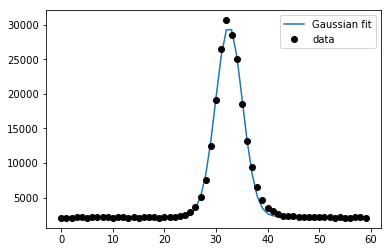

In [218]:
#using scipy
from scipy.optimize import curve_fit

def gauss(x, *params):
    A, mu, sigma, eps= params
    return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + eps

#estimate mean and standard deviation
ydata = np.copy(med_x[20:80])
xdata = np.array(range(len(ydata)))
mean = np.mean(ydata)
sigma = np.std(ydata)
#fitting
eps =0.1
popt, pcov = curve_fit(gauss, xdata, ydata, p0 = [3e4, mean, sigma, eps])

plt.plot(xdata,gauss(xdata, *popt), label='Gaussian fit')
plt.plot(xdata,ydata,'ok', label='data')
plt.legend()

print('A: {}\nmu: {}\nsigma= {}\neps: {}'.format(popt[0],popt[1], popt[2], popt[3]))

In [228]:
#covariance=0: no linear relationship; neg:; pos:
#diagonal is covariance of a variable with itself = variance
print(pcov)

[[  7.70299667e+04   8.79484633e-07  -4.21250825e+00  -3.49330798e+03]
 [  8.79484633e-07   8.80285229e-04  -8.65457806e-11   1.59876820e-08]
 [ -4.21250825e+00  -8.65457806e-11   9.67775874e-04  -6.57440962e-01]
 [ -3.49330798e+03   1.59876820e-08  -6.57440962e-01   4.94028339e+03]]


In [221]:
from scipy.stats import skew as skew
val = skew(ydata, axis=0)
val

2.4594531059265137

# Maximum Likelihood Estimate (MLE)

In [237]:
from scipy import optimize as op

#loss function
def log_like(params, x, y):     #params is a tuple
    A, mu, sigma, eps = params  #unpack
    y_model = A*np.exp(-(x-mu)**2/(2.*sigma**2)) + eps  #gaussian
    return -0.5 * np.sum(np.log(2*np.pi*sigma**2) + (y-y_model)**2 / sigma**2)

ydata = np.copy(med_x[20:80])
xdata = np.array(range(len(ydata)))
mean = np.mean(ydata)
sigma = np.std(ydata)
eps =0.1
x0 = [3e4, mean, sigma, eps]                    #init guess
args = (xdata, ydata)

#negative log likelihood
nll = lambda *x: -log_like(*x) #dummy x envelopes a tuple
print('Cost: {}'.format(nll(x0, xdata, ydata)))

804.36053983967099

Optimization terminated successfully.
A: 28120.199022783338
mu: 11254.876490205988
sigma= 7024.552112150625
eps: -2611.1879551112893


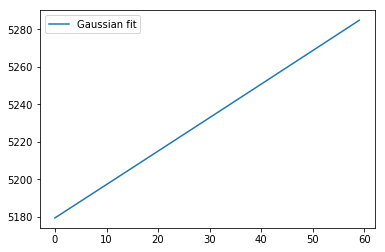

In [246]:
opt = op.minimize(nll, x0, args=args, method='bfgs')

plt.plot(xdata,gauss(xdata, *opt.x), label='Gaussian fit')
#plt.plot(xdata,ydata,'ok', label='data')
plt.legend()

print(opt.message)
print('A: {}\nmu: {}\nsigma= {}\neps: {}'.format(opt.x[0],opt.x[1], opt.x[2], opt.x[3]))

What a bad fit!

(20, 80)

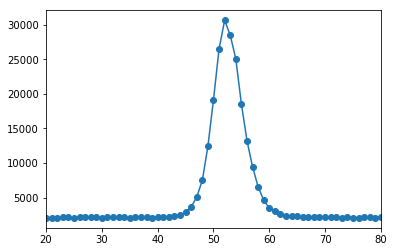

In [163]:
import pandas as pd

df = pd.DataFrame({'xdata':ydata}, index=xdata)
#using pandas

#ax = df.xdata.plot(kind='kde', linestyle='-') #there is scaling and amplitude error
ax = df.xdata.plot(marker='o')
ax.set_xlim([20,80])

In [178]:
#using gaussian mixture model
import numpy as np
from sklearn.mixture import GaussianMixture as gmm

gmm = gmm()
# result
r = gmm.fit(X=ydata[:, np.newaxis]) # GMM requires 2D data as of sklearn version 0.16
print("mean : %f, var : %f" % (r.means_[0, 0], r.covariances_[0, 0]))

mean : 3988.157139, var : 31952956.440602


In [186]:
ydata[:, np.newaxis][43:63]

array([[  2295.        ],
       [  2443.75585938],
       [  2867.8046875 ],
       [  3630.83496094],
       [  5077.0234375 ],
       [  7478.15625   ],
       [ 12411.4296875 ],
       [ 19137.43554688],
       [ 26496.62304688],
       [ 30654.75585938],
       [ 28492.2734375 ],
       [ 25079.78125   ],
       [ 18562.4921875 ],
       [ 13250.98046875],
       [  9459.80859375],
       [  6550.8046875 ],
       [  4625.30273438],
       [  3473.13476562],
       [  3010.3515625 ],
       [  2690.62109375]], dtype=float32)

In [188]:
r.predict(ydata[:, np.newaxis])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

### MCMC 

In [260]:
import emcee # version 2.0
#import multiprocessing

def log_prior(params): 
    A, mu, sigma, eps = params #unpack
    if sigma < 0:       #bound since sigma must be nonnegative
        return -np.inf  # = log(0)
    else:
        return (-1.5 * np.log(1 + mu**2) - np.log(sigma))
    if A < 0:
        return 30e3
    
    if mu < 20 or mu > 80:
        return 50
    
    if eps < -100 or eps > 100:
        return 0
    
def log_posterior(params, x, y): 
    return log_prior(params) + log_like(params,x,y)

In [268]:
ndim = 4 # number of parameters in the model 
nwalkers = 50 # number of MCMC walkers 
nburn = 1000 # "burn-in" to stabilize chains 
nsteps = 2000 # number of MCMC steps to take 


starting_guesses = np.random.rand(nwalkers, ndim)

In [270]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                args=[xdata,ydata], threads=-1)
sampler.run_mcmc(starting_guesses, nsteps)

# chain is of shape (nwalkers, nsteps, ndim)
# discard burn-in points and reshape
trace = sampler.chain[:, nburn:, :] 
trace = trace.reshape(-1, ndim)

theta_hat = np.percentile(trace, 50, axis=0)
print("A: {}\nmu: {}\nsigma: {}\neps:{}".format(*theta_hat))

A: 204558.2717329305
mu: 0.0943704614803082
sigma: 7292.855945559029
eps:-39271.78351135503


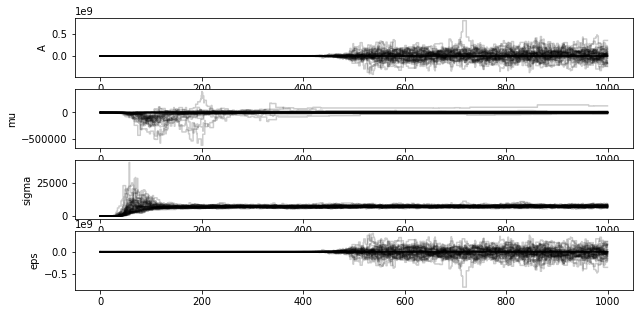

In [272]:
#before burn in
labels = ['A', 'mu', 'sigma', 'eps']
fig = plt.figure(figsize=(10,5))
for i, chain in enumerate(sampler.chain[:, :nburn, :].T): #up to nburn
    plt.subplot(4, 1, i+1)
    plt.plot(chain, drawstyle='steps', color='k', alpha=0.2)
    plt.ylabel(labels[i])

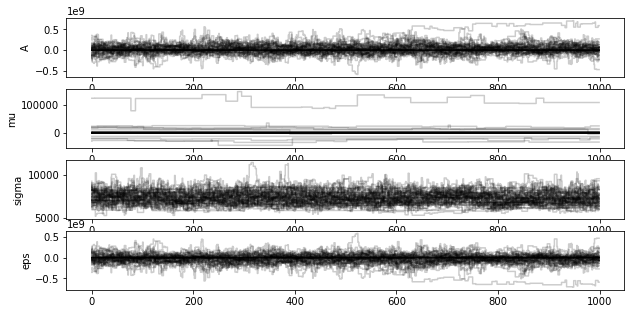

In [273]:
#after burn in
fig = plt.figure(figsize=(10,5))
for i, chain in enumerate(sampler.chain[:, nburn:, :].T): #from nburn
    plt.subplot(4, 1, i+1)
    plt.plot(chain, drawstyle='steps', color='k', alpha=0.2)
    plt.ylabel(labels[i])

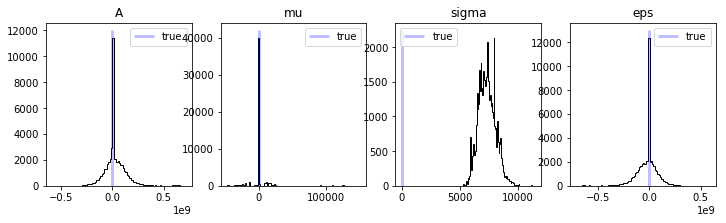

In [274]:
#posteriors
fig = plt.figure(figsize=(12,3))
for i in range(ndim):
    plt.subplot(1,4,i+1)
    plt.hist(trace[:,i], 100, color="k", histtype="step")
    yl = plt.ylim()
    plt.vlines(popt[i], yl[0], yl[1], color='blue', lw=3, alpha=0.25, label='true')
    plt.title("{}".format(labels[i]))
    plt.legend()

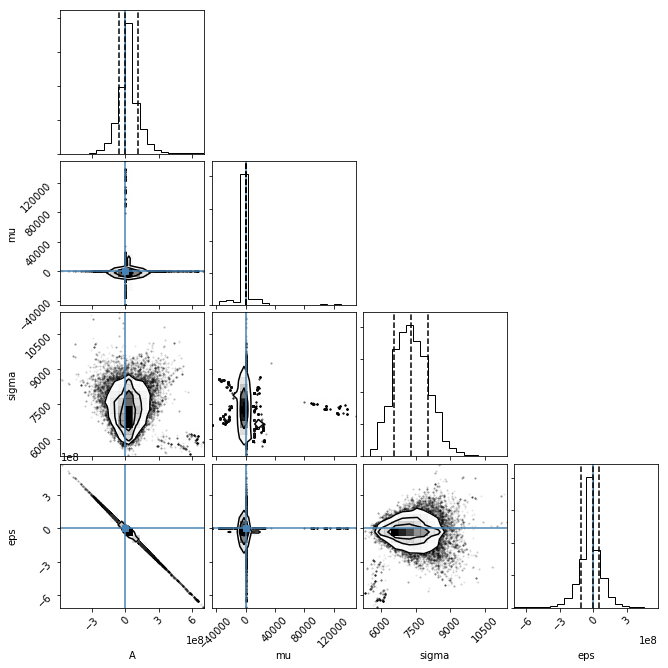

In [275]:
import corner
fig = corner.corner(trace, labels=labels, quantiles=[0.16, 0.5, 0.84], truths=popt)

## Manual source detection

### cropping a point source from eye-ball estimate

for one image

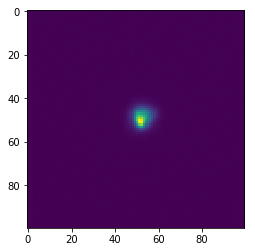

In [95]:
x_est, y_est = 701, 304
box_size = 100

sample_cropped = np.copy(gband_stacked[int(y_est-(box_size/2)):int(y_est+(box_size/2)),int(x_est-(box_size/2)):int(x_est+(box_size/2))])
plt.imshow(sample_cropped)

for stacked image

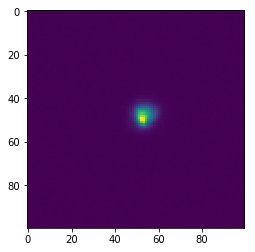

In [12]:
x_est, y_est = 701, 304
box_size = 100

gband_stacked_cropped = np.copy(gband_stacked[int(y_est-(box_size/2)):int(y_est+(box_size/2)),int(x_est-(box_size/2)):int(x_est+(box_size/2))])
plt.imshow(gband_stacked_cropped)

From above, I estimate that FWHM is about (55-43)= 8 pixels.

## Source Detection

[`photutil.DAOStarFinder`](http://photutils.readthedocs.io/en/stable/photutils/detection.html)

In [9]:
#first, estimate the background and background noise using sigma-clipped statistics:
from astropy.stats import sigma_clipped_stats

mean, median, std = sigma_clipped_stats(gband_stacked_cropped, sigma=3.0, iters=5)

In [10]:
print('mean={0}\nmedian={1}\nstd={2}'.format(mean, median, std))

mean=1732.8242945557538
median=1732.5322265625
std=30.028792428172338


As seen from plot above, point sources have peak more than 15e3. Let's use this as a cutoff. In multiple of sigma, this is about

In [13]:
max_value/std

1105.1937200566251

In [16]:
'''
use DAOStarFinder() to find the stars in the image that have 
FWHMs of around 8 pixels and have peaks approximately 5-sigma 
above the background
'''
daofind = DAOStarFinder(fwhm=8.0, threshold=1e2*std)
sources = daofind(gband_stacked - median)
sources[:5]

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,158.938742151,52.1058808179,0.401336066712,-0.156408555835,0.201076669537,121.0,0.0,2659.51074219,1.71919656452,-0.588313836578
2,914.952868098,263.969752988,0.410404396457,0.042157235873,0.237626998094,121.0,0.0,20486.6914062,14.0614551991,-2.87007566875
3,702.844263284,303.404157488,0.47877260091,0.00274733674804,0.231797996792,121.0,0.0,29736.1054688,19.8447785896,-3.2441156445
4,707.379883162,757.789408385,0.453461956087,0.0439495162419,0.152676620384,121.0,0.0,12411.3896484,8.52082185935,-2.32620371455
5,143.760988288,859.215439331,0.398626707989,-0.168771129908,0.0747678771262,121.0,0.0,6478.18847656,4.78288514066,-1.69922487891


In [43]:
from astropy.table import Table

def get_sources(image, num_sources=None, sigma_clip=None):
    '''
    returns positions and some statistics of point sources;
    photutils.DAOStarFinder() searches for local density maxima that have a peak amplitude 
    greater than threshold (approximately; threshold is applied to a convolved image) and 
    have a size and shape similar to the defined 2D Gaussian kernel;
    Gaussian kernel is defined by the fwhm, ratio, theta, and sigma_radius input parameters.
    Flux is calculated as the peak density in the convolved image divided by the detection threshold.
    '''
    
    if num_sources is None:
        num_sources=5
        #print('---showing 5 brightest sources (default)---')
        
    if sigma_clip is None:
        mean, median, std = sigma_clipped_stats(image, sigma=5, iters=5)
    else: #c.f. if sigma_clip:?
        mean, median, std = sigma_clipped_stats(image, sigma=sigma_clip, iters=5)
    
    #threshold: absolute image value above which to select sources
    #fwhm: of the major axis of the Gaussian kernel in pixels
    daofind = DAOStarFinder(fwhm=8.0, threshold=50.*std)
    sources = daofind(image - median)
    
    #get brightest sources
    sources = get_peak_sources(sources, num_sources)
    print('Top {0} brightest point sources:\n{1}'.format(num_sources,sources[:num_sources]))
    
    return sources

def get_peak_sources(sources, num_sources=None):
    '''
    returns brightest sources ranked by peak counts (in astropy.table format by default)
    '''
    #convert astropy tables to pandas.df to get sort by sources by peak
    df = sources.to_pandas()
    #df.set_index('id')
    
    if num_sources is None:
        #use pd to sort point sources by the peak column
        sources_df = df.sort_values(by='flux', ascending=False).head(3)
    else:
        sources_df = df.sort_values(by='flux', ascending=False).head(num_sources)
        
    #convert pandas back to astropy tables as required by CircularAperture() in show_sources()
    peak_sources = Table.from_pandas(sources_df)

    return peak_sources #in table format

#rank sourcces in stacked image by flux count
sources = get_sources(gband_stacked, num_sources=5, sigma_clip=100)

Top 5 brightest point sources:
 id   xcentroid     ycentroid   ...      peak          flux          mag      
--- ------------- ------------- ... ------------- ------------- --------------
  4 702.844263284 303.404157472 ... 29750.0957031 36.5642303551 -3.90764109085
  3 914.952868082    263.969753 ... 20500.6816406 25.9083925161 -3.53360117015
  6 707.379883162 757.789408385 ... 12425.3808594 15.6997118535 -2.98972920402
  7 143.760988288 859.215439331 ...  6492.1796875  8.8125206437 -2.36275036838
  1 158.938742151 52.1058808179 ... 2673.50195312 3.16763935781 -1.25183932605


In [18]:
#get the centroid of brightest point source to be used for cropping later

xcenter_init,ycenter_init = sources['xcentroid'][0], sources['ycentroid'][0] 
print(xcenter_init,ycenter_init)

702.63480501 304.048367349


## Cropping with fixed centroid

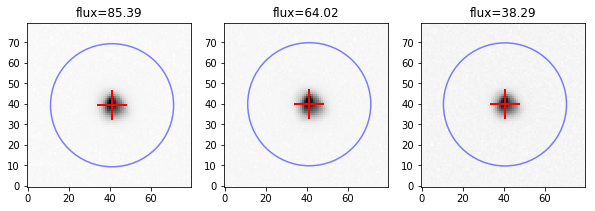

In [8]:
from photutils import centroid_2dg
from photutils import CircularAperture

def get_crop_images(image, sources, num_sources, box_size, aperture_radius_pix, show_image=None):
    '''
    returns cropped images of brightest point sources and their centroids
    '''
    #get only the top 5 brightest sources
    sources=sources[:num_sources]
    
    x,y = (sources['xcentroid'], sources['ycentroid'])
    
    column = 0
    source_images = []
    apertures = []
    
    if show_image is True:
        fig, ax = plt.subplots(nrows=1, ncols=num_sources, figsize=(10,10))
        
    for i,j in zip(x,y):
        point_source = np.copy(image[int(j-(box_size/2)):int(j+(box_size/2)),int(i-(box_size/2)):int(i+(box_size/2))]) #y1:y2,x1:x2
        source_images.append(point_source);
        
        #recompute new centroid within cropped image
        xcenter, ycenter, aperture = get_centroid(point_source, aperture_radius_pix);
        apertures.append(aperture)
            
        if show_image is True:
            norm = ImageNormalize(stretch=SqrtStretch())
            ax[column].imshow(point_source, cmap='Greys', origin='lower', norm=norm)
            ax[column].plot(xcenter, ycenter, color='red', marker='+', ms=30, mew=2)
            ax[column].set_title('flux={0:.2f}'.format(sources['flux'][column]))
            aperture.plot(color='blue', lw=1.5, alpha=0.5, ax=ax[column]);
            column+=1
        
    return source_images, apertures

def get_centroid(image, aperture_radius_pix):
    '''
    get centroid from fitting a 2D gaussian around the centroid
    '''
    xcenter, ycenter = centroid_2dg(image);
    aperture = CircularAperture([xcenter, ycenter], r=aperture_radius_pix);
    
    return xcenter, ycenter, aperture

source_images, apertures = get_crop_images(gband_stacked, sources, num_sources=3, box_size=80, aperture_radius_pix=30, show_image=True);

## Photometry with fixed aperture and initial centroid

In [95]:
import pandas as pd

#xcenter_init,ycenter_init = sources['xcentroid'][0], sources['ycentroid'][0] 
xcenter_init,ycenter_init = 702.63, 304.05
box_size=80

xcenters, ycenters = [], []
fluxes = []
areas = []
obs_time = []
obs_mjd  = []
#source_images = []

for i in gband[:20]:
    hdr = pf.open(i)[0].header
    img = pf.open(i)[0].data

    #get dates from fits header
    date=dt.strptime(hdr['DATE-OBS'], '%Y-%m-%d')
    time=dt.strptime(hdr['EXP-STRT'], '%H:%M:%S.%f')
    #newdate = time.replace(year=date.year, month=date.month, day=date.day)
    obs_time.append(newdate)
    obs_mjd.append(hdr['MJD-STRT'])

    #crop
    point_source = np.copy(img[int(ycenter_init-(box_size/2)):int(ycenter_init+(box_size/2)),int(xcenter_init-(box_size/2)):int(xcenter_init+(box_size/2))]) #y1:y2,x1:x2
    #source_images.append(point_source)

    #photometry: compute flux within and background noise outside aperture 
    mean, median, std = sigma_clipped_stats(img, sigma=3.0, iters=5)  
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
    sources = daofind(img - median)

    flux = sources.to_pandas()['flux'][0]
    xcenter = sources.to_pandas()['xcentroid'][0]
    ycenter = sources.to_pandas()['ycentroid'][0]
    fluxes.append(flux)
    xcenters.append(xcenter)
    ycenters.append(ycenter)
    
    #compare centroid with DAOStarFinder()
    #xcenter_new, ycenter_new, aperture = get_centroid(img, aperture_radius_pix=30)
    #area = aperture.area()
    #areas.append(area)

#output as dataframe
d = {'xcenter' : xcenters,
     'ycenter' : ycenters,
     'flux'    : fluxes}

df_gband = pd.DataFrame(d, index = obs_time)
#df_gband.head()